<a href="https://colab.research.google.com/github/neilkale/vector-diagnosis/blob/main/cs4231_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Final Project
Vector-Borne Disease Prediction | 04-25-2023 \
Authors: Neil Kale, David Gobran, Arjun Venat

## Loading the Data

In [ ]:
import numpy as np
import pandas as pd

trainData = pd.read_csv("train.csv",
                 delimiter=",")
testData = pd.read_csv("test.csv",
                 delimiter=",")

# symptom clusters:
# cluster_0 = trainData.columns[trainData.columns.str.contains('pain')]
# cluster_1 = trainData.columns[trainData.columns.str.contains('inflammation')]
# cluster_2 = trainData.columns[trainData.columns.str.contains('bleed')]
# cluster_3 = trainData.columns[trainData.columns.str.contains('skin')].tolist() + ['itchiness']
# trainData['cluster_0'] = trainData[cluster_0].sum(axis=1)
# trainData['cluster_1'] = trainData[cluster_1].sum(axis=1)
# trainData['cluster_2'] = trainData[cluster_2].sum(axis=1)
# trainData['cluster_3'] = trainData[cluster_3].sum(axis=1)
# cluster_0 = testData.columns[testData.columns.str.contains('pain')]
# cluster_1 = testData.columns[testData.columns.str.contains('inflammation')]
# cluster_2 = testData.columns[testData.columns.str.contains('bleed')]
# cluster_3 = testData.columns[testData.columns.str.contains('skin')].tolist() + ['itchiness']
# testData['cluster_0'] = testData[cluster_0].sum(axis=1)
# testData['cluster_1'] = testData[cluster_1].sum(axis=1)
# testData['cluster_2'] = testData[cluster_2].sum(axis=1)
# testData['cluster_3'] = testData[cluster_3].sum(axis=1)

# column_to_move = trainData.pop("prognosis")
# trainData.insert(0, "prognosis", column_to_move)
# display(trainData)

# trainX is an m x n array where each column is a datapoint
trainX = trainData.to_numpy()[:,1:-1].T.astype("int")
# trainY is a 1-D categorical array of length n, y_labels stores the categories
trainY = trainData.to_numpy()[:,-1]

# testX is an m x n array where each column is a datapoint
testX = testData.to_numpy()[:,1:].T.astype("int")
# testLabels is a 1-D array of length n storing the labels of the test data
test_ids = testData.to_numpy()[:,0].astype("int")

_, unique_idx, trainY_categorical = np.unique(trainY,return_index=True,return_inverse=True)
diseases = trainY[unique_idx]
trainY = trainY_categorical.astype("int")

## Exploring the Data

### Correlation Matrix

<ipython-input-23-cadfbf020392>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = trainData.corr()


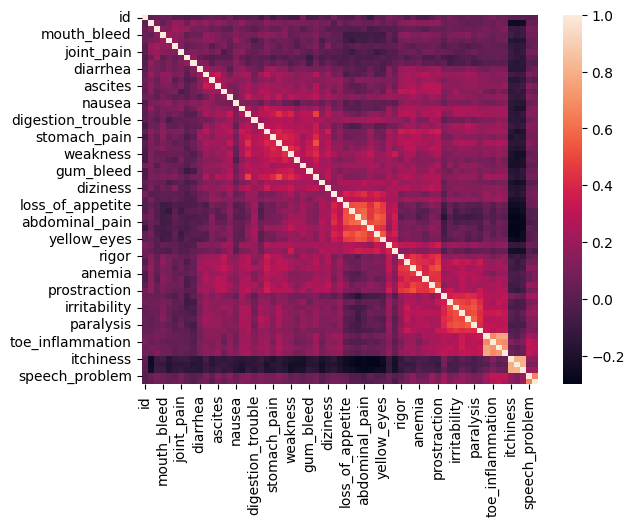

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix = trainData.corr()
sn.heatmap(corr_matrix, annot=False)
plt.show()

### Dataset with Interaction Terms

In [ ]:
# m = np.shape(trainX)[0]
# n = np.shape(trainX)[1]

# trainX_withInteractions = np.zeros((m+m*(m-1)+m*(m-1),n))

# for i in range(m*(m-1)):
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True,include_bias=False)
trainX_withInteractions = poly.fit_transform(trainX.T).T
print(np.shape(trainX_withInteractions))

(2080, 707)


### Scaled Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
trainX_scaled = ss.fit_transform(trainX)

## Computation of Baseline Accuracy

In [ ]:
# Computes the most frequent y-label in the dataset
y_freq = np.bincount(trainY).argmax()
print("The most frequent y-label is", diseases[y_freq])
testY_baseline = np.full((np.shape(testX)[1],3),y_freq)
create_guess_file(testY_baseline, "baseline")

# The baseline accuracy is 0.099 on the Kaggle test data.

The most frequent y-label is West_Nile_fever


## Visualize the Data

In [ ]:
print(np.bincount(trainY))
print(len(trainY))
print(diseases)
print(max(np.bincount(trainY))/len(trainY))

[66 63 81 52 48 53 70 70 85 61 58]
707
['Chikungunya' 'Dengue' 'Japanese_encephalitis' 'Lyme_disease' 'Malaria'
 'Plague' 'Rift_Valley_fever' 'Tungiasis' 'West_Nile_fever' 'Yellow_Fever'
 'Zika']
0.12022630834512023


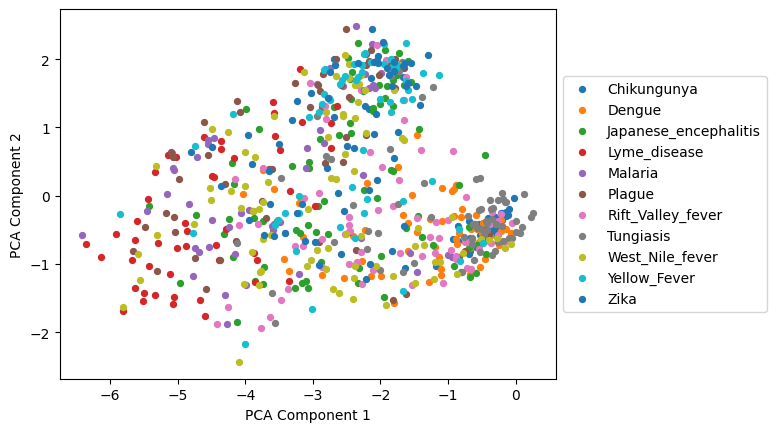

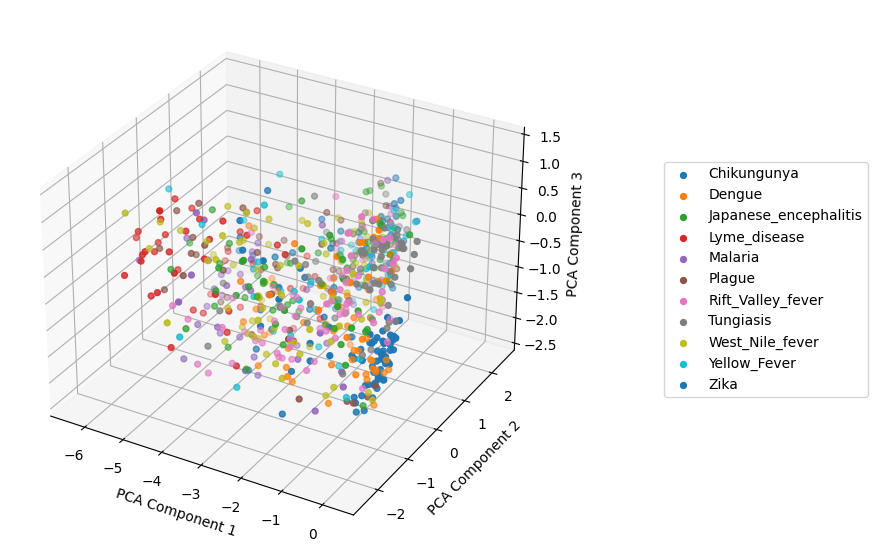

In [ ]:
import matplotlib.pyplot as plt

# Implements PCA
x_bar = np.mean(trainX,axis=1)
X_tilde = trainX - x_bar[:,None]
w,v = np.linalg.eig( np.dot(X_tilde, X_tilde.T))

# 2D PCA Scatter
pc = v[:,[0,1]]
X_pc = np.dot(pc.T, trainX)

for i in range(len(diseases)):
  locs = (trainY == i)
  plt.scatter(X_pc[0,locs],X_pc[1,locs],s=18)

plt.legend(diseases,loc="center left",bbox_to_anchor=(1, 0.5))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# 3D PCA Scatter
pc = v[:,[0,1,2]]
X_pc = np.dot(pc.T, trainX)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(len(diseases)):
  locs = (trainY == i)
  ax.scatter3D(X_pc[0,locs],X_pc[1,locs],X_pc[2,locs],s=18)

plt.legend(diseases,loc="center left",bbox_to_anchor=(1.2, 0.5))
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

plt.show()

## A Note on Validation

Since the dataset is only 707 datapoints, we elected to use 5-fold cross validation instead of just a 20% hold-out set.

## Shallow Models

### Softmax (Logistic) Regression

In [ ]:
from types import prepare_class
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# trainY_onehot = np.zeros((len(trainY), len(diseases)))
# trainY_onehot[np.arange(len(trainY)), trainY] = 1

logreg  = LogisticRegression(C=0.1, max_iter=10000, multi_class='ovr', solver='sag')

# 5-Fold CV to predict the model accuracy
scores = cross_val_score(logreg, trainX.T, trainY, cv=5)
print("Predicted Accuracy:", np.mean(scores))

# Train a final model and save the predictions
logreg.fit(trainX.T, trainY)
testY_LR = logreg.predict_proba(testX.T)

testY_LR = np.flip(np.argsort(testY_LR,axis=1),axis=1)[:,0:3]
create_guess_file(testY_LR,"logreg")

Predicted Accuracy: 0.30844071521326544



###Linear Disciminant Analysis

In [ ]:
from types import prepare_class
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# trainY_onehot = np.zeros((len(trainY), len(diseases)))
# trainY_onehot[np.arange(len(trainY)), trainY] = 1

LDA  = LinearDiscriminantAnalysis()

# 5-Fold CV to predict the model accuracy
scores = cross_val_score(LDA, trainX.T, trainY, cv=5)
print("Predicted Accuracy:", np.mean(scores))
# Train a final model and save the predictions
LDA.fit(trainX.T, trainY)
testY_LDA = LDA.predict_proba(testX.T)

testY_LDA = np.flip(np.argsort(testY_LDA,axis=1),axis=1)[:,0:3]
create_guess_file(testY_LDA,"LDA")

Predicted Accuracy: 0.31557286984317245


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# 5-Fold CV to predict the model accuracy
rf  = RandomForestClassifier(n_estimators=200,max_depth=7,criterion="gini",max_features="sqrt")
scores = cross_val_score(rf, trainX.T, trainY, cv=5)
# scores = cross_val_score(rf, trainX_withInteractions.T, trainY, cv=5) # feature aggregation
print("Predicted Accuracy:", np.mean(scores))

# 5-Fold CV with GridSearch
# Results:
#  {'criterion': 'gini',
#  'max_depth': 7,
#  'max_features': 'sqrt',
#  'n_estimators': 200}
# rfc  = RandomForestClassifier(n_estimators=200)
# param_grid = {
#     'n_estimators': [200, 500],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(trainX.T, trainY)
# print(CV_rfc.best_params_)

# Train a final model and save the predictions
rf.fit(trainX.T, trainY)
testY_RF = rf.predict_proba(testX.T)

testY_RF = np.flip(np.argsort(testY_RF,axis=1),axis=1)[:,0:3]
create_guess_file(testY_RF,"rf")

Predicted Accuracy: 0.30700229747277996


## 3-Layer Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader

# Define the neural network architecture
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x

# Define the hyperparameters
input_size = np.shape(trainX)[0]
hidden_size = 30
num_classes = len(diseases)
learning_rate = 0.001
num_epochs = 30
batch_size = 50

# Set up the dataset
train_x = torch.from_numpy(trainX.T).float()
train_y = torch.from_numpy(trainY).long()
dataset = TensorDataset(train_x, train_y)

# Create the cross-validation splits
kfold = KFold(n_splits=5, shuffle=True)

# Variables for calculating the average accuracy over all folds
TOTAL = 0
CORRECT = 0

# Train and test the neural network on each fold
for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
  print('Fold', fold+1)
  # Split the dataset into train and test sets for this fold
  train_dataset = torch.utils.data.Subset(dataset, train_idx)
  test_dataset = torch.utils.data.Subset(dataset, test_idx)
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  # Create the neural network
  net = Net(input_size, hidden_size, num_classes)
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)


  # Train the neural network
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(train_loader, 0):

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # Print statistics
          running_loss += loss.item()
          if i % 100 == 99:
              print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
              running_loss = 0.0

  print('Finished training')

  # Test the neural network
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy on test set: %d %%' % (100 * correct / total))
  TOTAL += total
  CORRECT += correct
  print()

print("Mean predicted accuracy: %d %%" % (100 * CORRECT / TOTAL))

Fold 1
Finished training
Accuracy on test set: 30 %

Fold 2
Finished training
Accuracy on test set: 22 %

Fold 3
Finished training
Accuracy on test set: 26 %

Fold 4
Finished training
Accuracy on test set: 30 %

Fold 5
Finished training
Accuracy on test set: 33 %

Mean predicted accuracy: 28 %


Now, we train a final model and save the predictions to '3nn_submission.csv'

In [ ]:
train_dataset = dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the neural network
net = Net(input_size, hidden_size, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Train the neural network
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0

print('Finished training')

test_x = torch.from_numpy(testX.T).float()
test_dataset = TensorDataset(test_x)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
testY_3nn = np.zeros((1,3))

with torch.no_grad():
    for data in test_loader:
        inputs = data[0]
        outputs = net(inputs)
        _, predicted = torch.topk(outputs.data, k=3)
        # print(predicted.numpy())
        testY_3nn = np.vstack((testY_3nn, predicted.numpy()))

testY_3nn = testY_3nn[1:,:].astype("int")
print(np.shape(testY_3nn))
create_guess_file(testY_3nn,"3nn")

Finished training
(303, 3)


##Deep Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader

class Net(nn.Module):
  def __init__(self, input_size, num_hidden_layers, hidden_size, num_classes):
    super(Net, self).__init__()
    self.fc_layers = nn.ModuleList()
    # input layer
    self.fc_layers.append(nn.Linear(input_size, hidden_size[0]))
    self.fc_layers.append(nn.ReLU())
    # hidden layers
    for i in range(num_hidden_layers-1):
        self.fc_layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
        self.fc_layers.append(nn.ReLU())
    # output layer
    self.fc_layers.append(nn.Linear(hidden_size[-1], num_classes))

  def forward(self, x):
    for layer in self.fc_layers:
        x = layer(x)
    return x

# Define the hyperparameters
input_size = np.shape(trainX)[0]
num_hidden_layers = 3
hidden_size = [30] * num_hidden_layers
num_classes = len(diseases)
learning_rate = 0.001
num_epochs = 30
batch_size = 50

# Set up the dataset
train_x = torch.from_numpy(trainX.T).float()
train_y = torch.from_numpy(trainY).long()
dataset = TensorDataset(train_x, train_y)

# Create the cross-validation splits
kfold = KFold(n_splits=5, shuffle=True)

# Variables for calculating the average accuracy over all folds
TOTAL = 0
CORRECT = 0

# Train and test the neural network on each fold
for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
  print('Fold', fold+1)
  # Split the dataset into train and test sets for this fold
  train_dataset = torch.utils.data.Subset(dataset, train_idx)
  test_dataset = torch.utils.data.Subset(dataset, test_idx)
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  # Create the neural network
  net = Net(input_size, num_hidden_layers, hidden_size, num_classes)
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)


  # Train the neural network
  for epoch in range(num_epochs):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(train_loader, 0):

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # Print statistics
          running_loss += loss.item()
          if i % 100 == 99:
              print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
              running_loss = 0.0

  print('Finished training')

  # Test the neural network
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy on test set: %d %%' % (100 * correct / total))
  TOTAL += total
  CORRECT += correct
  print()

print("Mean predicted accuracy: %d %%" % (100 * CORRECT / TOTAL))

Fold 1
Finished training
Accuracy on test set: 24 %

Fold 2
Finished training
Accuracy on test set: 30 %

Fold 3
Finished training
Accuracy on test set: 26 %

Fold 4
Finished training
Accuracy on test set: 21 %

Fold 5
Finished training
Accuracy on test set: 24 %

Mean predicted accuracy: 25 %


Save prediction file 'Nnn_submission.csv' where N is the number of layers

In [ ]:
train_dataset = dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the neural network
net = Net(input_size, num_hidden_layers, hidden_size, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Train the neural network
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0

print('Finished training')

test_x = torch.from_numpy(testX.T).float()
test_dataset = TensorDataset(test_x)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
testY_dnn = np.zeros((1,3))

with torch.no_grad():
    for data in test_loader:
        inputs = data[0]
        outputs = net(inputs)
        _, predicted = torch.topk(outputs.data, k=3)
        # print(predicted.numpy())
        testY_dnn = np.vstack((testY_dnn, predicted.numpy()))

testY_dnn = testY_dnn[1:,:].astype("int")
print(np.shape(testY_dnn))
create_guess_file(testY_dnn, f"{num_hidden_layers+2}nn")

Finished training
(303, 3)


###Grid Search

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid

# Define the neural network architecture
class Net(nn.Module):
  def __init__(self, input_size, num_hidden_layers, hidden_size, num_classes):
    super(Net, self).__init__()
    self.fc_layers = nn.ModuleList()
    # input layer
    self.fc_layers.append(nn.Linear(input_size, hidden_size[0]))
    self.fc_layers.append(nn.ReLU())
    # hidden layers
    for i in range(num_hidden_layers-1):
        self.fc_layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
        self.fc_layers.append(nn.ReLU())
    # output layer
    self.fc_layers.append(nn.Linear(hidden_size[-1], num_classes))

  def forward(self, x):
    for layer in self.fc_layers:
        x = layer(x)
    return x

# Set up the dataset
train_x = torch.from_numpy(trainX.T).float()
train_y = torch.from_numpy(trainY).long()
dataset = TensorDataset(train_x, train_y)

# Define the hyperparameters
num_hidden_layers = 3
input_size = np.shape(trainX)[0]
num_classes = len(diseases)

# Define the hyperparameters to search over
params = {
    'hidden_sizes': [[30, 30, 30], [40, 40, 40], [50, 50, 50]],
    'learning_rate': [0.01, 0.001, 0.0001],
    'num_epochs': [30, 50, 100],
    'batch_size': [30, 50, 100]
}

# Create the cross-validation splits
kfold = KFold(n_splits=5, shuffle=True)

# Train and test the neural network on each combination of hyperparameters
best_accuracy, best_hyperparams = 0, None
for hyperparams in ParameterGrid(params):
  print('Testing:', hyperparams)
  accuracy = 0
  # Variables for calculating the average accuracy over all folds
  TOTAL = 0
  CORRECT = 0
  # Train and evaluate the neural network on each fold
  for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    # Split the dataset into train and test sets for this fold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hyperparams['batch_size'], shuffle=False)
    # Create the neural network
    net = Net(input_size, num_hidden_layers, hyperparams['hidden_sizes'], num_classes)
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=hyperparams['learning_rate'])
    # Train the neural network
    for epoch in range(hyperparams['num_epochs']):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(train_loader, 0):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
        running_loss = 0.0

    # Evaluate the model on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    TOTAL += total
    CORRECT += correct

  mean_accuracy = 100 * CORRECT / TOTAL
  print('Mean predicted accuracy: %.3f%%' % mean_accuracy)
  # Keep track of best hyperparams
  if (mean_accuracy > best_accuracy):
    best_accuracy = mean_accuracy
    best_hyperparams = hyperparams

# Show best hyperparameters found
print(f"{best_accuracy} for {best_hyperparams}")

Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.01, 'num_epochs': 30}
Mean predicted accuracy: 27.016%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.01, 'num_epochs': 50}
Mean predicted accuracy: 25.318%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.01, 'num_epochs': 100}
Mean predicted accuracy: 26.025%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.001, 'num_epochs': 30}
Mean predicted accuracy: 29.420%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.001, 'num_epochs': 50}
Mean predicted accuracy: 26.733%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.001, 'num_epochs': 100}
Mean predicted accuracy: 25.884%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_rate': 0.0001, 'num_epochs': 30}
Mean predicted accuracy: 14.427%
Testing: {'batch_size': 30, 'hidden_sizes': [30, 30, 30], 'learning_r

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective="multi:softprob")

# 5-Fold CV to predict the model accuracy
scores = cross_val_score(xgb_model, trainX.T, trainY, cv=5)
print("Predicted Accuracy:", np.mean(scores))

# Train a final model and save the predictions
xgb_model.fit(trainX.T, trainY)
testY_XGB = xgb_model.predict_proba(testX.T)

testY_XGB = np.flip(np.argsort(testY_XGB,axis=1),axis=1)[:,0:3]
create_guess_file(testY_XGB,"XGB")

Predicted Accuracy: 0.294216362001798


## Helper Functions

In [ ]:
# Given an n x 3 numpy array of best/second-best/third-best guesses, returns
#   a .csv file to pass to Kaggle.
def create_guess_file(testY, file_name):
  testY = categories_to_diseases(testY)
  testY = np.apply_along_axis(row_to_str, 1, testY)
  output = np.concatenate([test_ids[:,None],testY[:,None]],axis=1)
  np.savetxt(file_name+"_submission.csv", output, delimiter = ',', fmt = '%s', header='id,prognosis',comments='')

# Converts an n x 3 integer array to a string array of corresponding diseases
def categories_to_diseases(guesses):
  return np.array([diseases[guess] for guess in guesses])

# Converts the array [[1,2,3],[4,5,6]] into ["1 2 3", "4 5 6"]
def row_to_str(row):
    return " ".join(str(x) for x in row)